<a href="https://colab.research.google.com/github/Kreeti889/Cancer-Detection-Using-Machine-Learning/blob/main/Cancer_Detection_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install kaggle

In [ ]:
from google.colab import files
print("Upload kaggle.json (from your Kaggle account)...")
_ = files.upload()

Upload kaggle.json (from your Kaggle account)...


Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir -p ~/.kaggle
!mv -f kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/data

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 55% 81.0M/149M [00:00<00:00, 841MB/s]
100% 149M/149M [00:00<00:00, 609MB/s] 


In [ ]:
!unzip -q -o /content/data/brain-tumor-mri-dataset.zip -d /content/data
!find /content/data -maxdepth 2 -type d -print

/content/data
/content/data/Training
/content/data/Training/meningioma
/content/data/Training/pituitary
/content/data/Training/notumor
/content/data/Training/glioma
/content/data/Testing
/content/data/Testing/meningioma
/content/data/Testing/pituitary
/content/data/Testing/notumor
/content/data/Testing/glioma


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


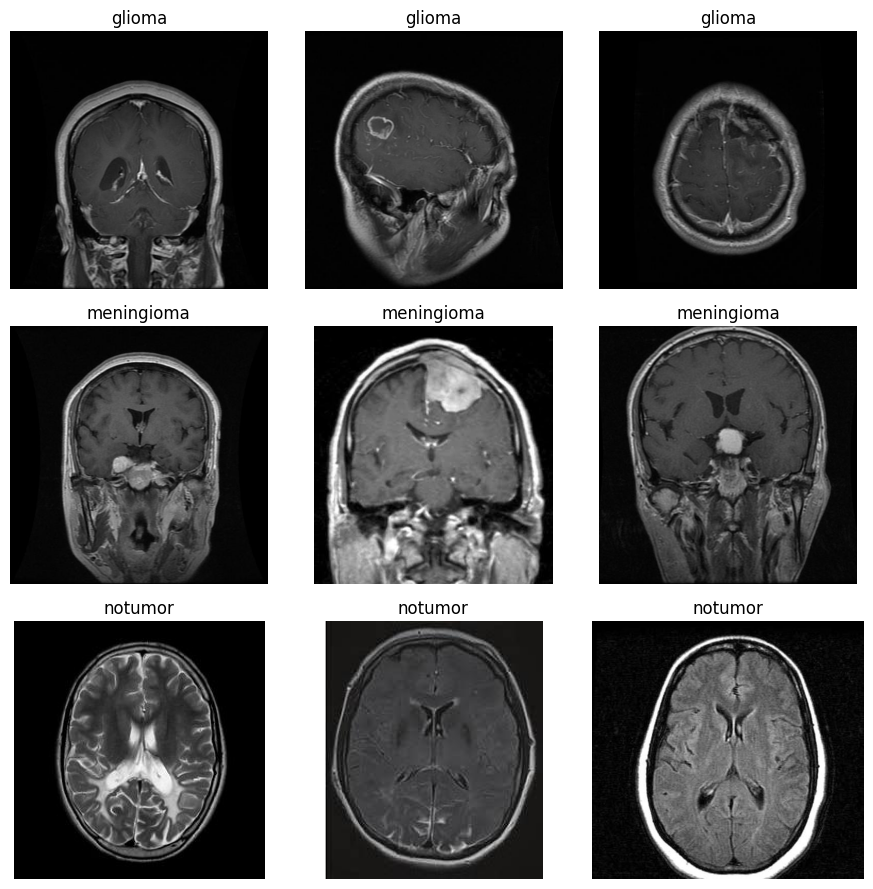

In [ ]:
import os, glob, itertools, random
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image

train_dir = "/content/data/Training"
test_dir  = "/content/data/Testing"

classes = sorted(next(os.walk(train_dir))[1])
print("Classes:", classes)

def count_images(root):
    counts = {}
    for c in classes:
        counts[c] = len(glob.glob(os.path.join(root, c, "*")))
    return counts

print("Train counts:", count_images(train_dir))
print("Test counts:", count_images(test_dir))

# Show a small sample grid
samples = []
for c in classes:
    paths = glob.glob(os.path.join(train_dir, c, "*"))
    samples.extend(random.sample(paths, min(3, len(paths))))

plt.figure(figsize=(9,9))
for i, p in enumerate(samples[:9], 1):
    img = Image.open(p).convert("RGB")
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(p)))
    plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH    = 32
SEED     = 42

# We'll create train+val from /Training and use /Testing as test.
trainval_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="int", shuffle=True, seed=SEED, validation_split=0.2, subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="int", shuffle=True, seed=SEED, validation_split=0.2, subset="validation"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="int", shuffle=False
)

class_names = trainval_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

# Performance: cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
trainval_ds = trainval_ds.cache().prefetch(AUTOTUNE)
val_ds     = val_ds.cache().prefetch(AUTOTUNE)
test_ds    = test_ds.cache().prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10),
])

preprocess = tf.keras.Sequential([
    layers.Rescaling(1./255)
])


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Base (ImageNet)
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
base.trainable = False  # Phase 1: freeze

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = preprocess(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # cast back to float32 if mixed precision
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
trainval_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH,
    color_mode="rgb",   # force 3 channels
    label_mode="int", shuffle=True, seed=SEED, validation_split=0.2, subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH,
    color_mode="rgb",
    label_mode="int", shuffle=True, seed=SEED, validation_split=0.2, subset="validation"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH,
    color_mode="rgb",
    label_mode="int", shuffle=False
)



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [ ]:
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)


In [ ]:
trainval_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH,
    color_mode="rgb",       # 👈 ensure 3 channels
    label_mode="int", shuffle=True, seed=SEED, validation_split=0.2, subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH,
    color_mode="rgb",
    label_mode="int", shuffle=True, seed=SEED, validation_split=0.2, subset="validation"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH,
    color_mode="rgb",
    label_mode="int", shuffle=False
)



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [ ]:
loss="sparse_categorical_crossentropy"


In [ ]:
for images, labels in trainval_ds.take(1):
    print("Images:", images.shape, images.dtype)
    print("Labels:", labels.shape, labels.dtype)


Images: (32, 224, 224, 3) <dtype: 'float32'>
Labels: (32,) <dtype: 'int32'>


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

base_model = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

# ✅ Ensure output is float32 (important with mixed precision)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    trainval_ds,
    validation_data=val_ds,
    epochs=10
)




Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.3512 - loss: 1.3752 - val_accuracy: 0.6576 - val_loss: 1.0003
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.6251 - loss: 0.9944 - val_accuracy: 0.7496 - val_loss: 0.8032
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.7138 - loss: 0.8189 - val_accuracy: 0.7820 - val_loss: 0.6883
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.7659 - loss: 0.7130 - val_accuracy: 0.8100 - val_loss: 0.6119
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.7886 - loss: 0.6316 - val_accuracy: 0.8222 - val_loss: 0.5558
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.8005 - loss: 0.5850 - val_accuracy: 0.8389 - val_loss: 0.5140
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.8245 - loss: 0.5400 - val_accuracy: 0.8468 - val_loss: 0.4824
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8359 - loss: 0.5125 - val_accu

In [ ]:
# Access training history
h = history.history

# Check available keys
print(h.keys())   # This will show: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Optional: convert to a list
keys_list = list(h.keys())
print(keys_list)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
['accuracy', 'loss', 'val_accuracy', 'val_loss']


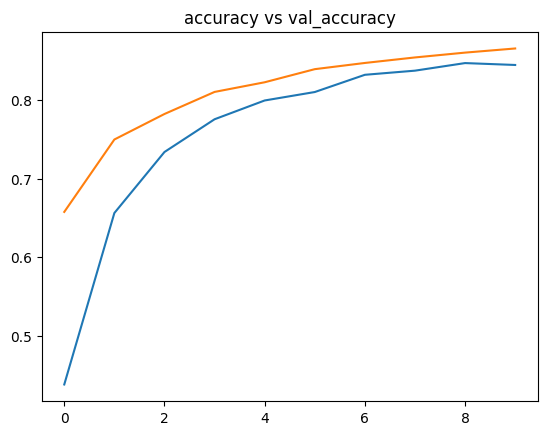

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])

plt.title("accuracy vs val_accuracy")
plt.show()

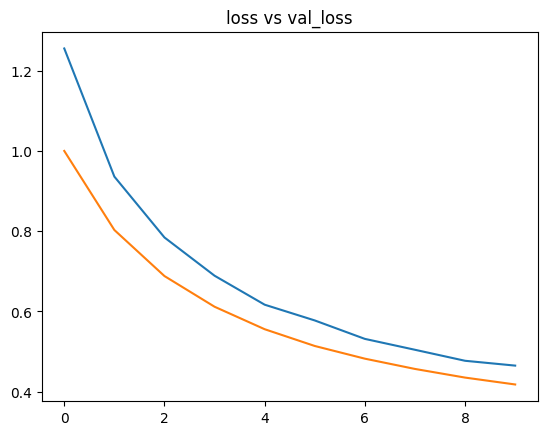

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'])

plt.title("loss vs val_loss")
plt.show()

In [ ]:
# Evaluate the model on the test dataset
acc = model.evaluate(test_ds)[1]

# Print test accuracy as a percentage
print(f"Test accuracy: {acc*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7516 - loss: 0.5911
Test accuracy: 80.70%


In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# Load image
path = "/content/data/Training/meningioma/Tr-me_0012.jpg"
img = load_img(path, target_size=(224, 224))
input_arr = img_to_array(img) / 255.0

# Expand dimensions to match model input shape (batch size 1)
input_arr = np.expand_dims(input_arr, axis=0)

# Predict probabilities
pred_prob = model.predict(input_arr)

# Get predicted class index
pred_class = np.argmax(pred_prob, axis=1)[0]

print("Predicted class index:", pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted class index: 0


In [ ]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


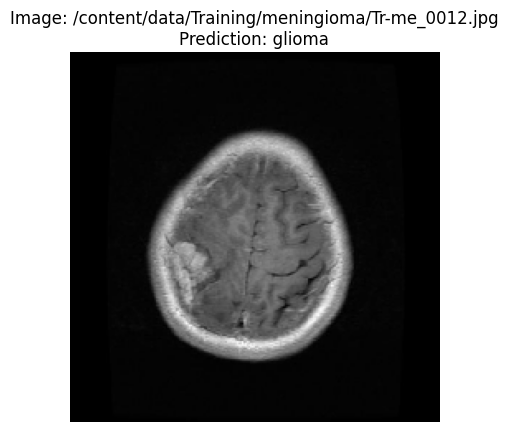

Image: /content/data/Training/meningioma/Tr-me_0012.jpg
Tumor detected: glioma


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# -------------------------
# Step 1: Set the image path manually
image_path = "/content/data/Training/meningioma/Tr-me_0012.jpg"  # Replace with your image
# -------------------------

# -------------------------
# Step 2: Class mapping
# Make sure it matches your training generator's class indices
index_to_class = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
# -------------------------

# -------------------------
# Step 3: Load and preprocess image
img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
input_arr = img_to_array(img) / 255.0  # normalize
input_arr_exp = np.expand_dims(input_arr, axis=0)
# -------------------------

# -------------------------
# Step 4: Predict
pred_prob = model.predict(input_arr_exp)
pred_class_idx = np.argmax(pred_prob, axis=1)[0]
pred_class_name = index_to_class[pred_class_idx]

# -------------------------
# Step 5: Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {image_path}\nPrediction: {pred_class_name}")
plt.show()

# -------------------------
# Step 6: Check tumor presence
if pred_class_name == 'notumor':
    print(f"Image: {image_path}")
    print("No tumor detected in the image.")
else:
    print(f"Image: {image_path}")
    print(f"Tumor detected: {pred_class_name}")
# -------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


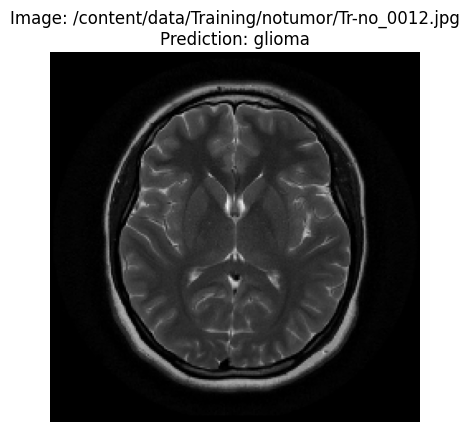

Image: /content/data/Training/notumor/Tr-no_0012.jpg
Tumor detected: glioma


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# -------------------------
# Step 1: Set the image path manually to a 'no tumor' image
image_path = "/content/data/Training/notumor/Tr-no_0012.jpg"  # Replace with your 'notumor' image
# -------------------------

# -------------------------
# Step 2: Class mapping
# Make sure it matches your training generator's class indices
index_to_class = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
# -------------------------

# -------------------------
# Step 3: Load and preprocess image
img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
input_arr = img_to_array(img) / 255.0  # normalize
input_arr_exp = np.expand_dims(input_arr, axis=0)
# -------------------------

# -------------------------
# Step 4: Predict
pred_prob = model.predict(input_arr_exp)
pred_class_idx = np.argmax(pred_prob, axis=1)[0]
pred_class_name = index_to_class[pred_class_idx]

# -------------------------
# Step 5: Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {image_path}\nPrediction: {pred_class_name}")
plt.show()

# -------------------------
# Step 6: Check tumor presence
if pred_class_name == 'notumor':
    print(f"Image: {image_path}")
    print("No tumor detected in the image.")
else:
    print(f"Image: {image_path}")
    print(f"Tumor detected: {pred_class_name}")
# -------------------------


In [ ]:
pred_prob = model.predict(input_arr_exp)
print(pred_prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[0.86738575 0.0747704  0.04285216 0.0149917 ]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import class_weight
import numpy as np

# -------------------------
# Paths and parameters
train_dir = "/content/data/Training/"
img_size = (224, 224)
batch_size = 32
# -------------------------

# -------------------------
# Data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation
)

train_ds = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_ds = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
# -------------------------

# -------------------------
# Compute class weights
y_train = train_ds.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)
# -------------------------

# -------------------------
# Simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -------------------------
# Train with class weights
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=class_weights
)

# Save retrained model
model.save("/content/retrained_model.h5")
print("Model retrained and saved!")
# -------------------------


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.3731 - loss: 1.7688 - val_accuracy: 0.6231 - val_loss: 0.9487
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - accuracy: 0.6483 - loss: 0.8415 - val_accuracy: 0.5215 - val_loss: 1.0322
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.6790 - loss: 0.7723 - val_accuracy: 0.6976 - val_loss: 0.8002
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.7203 - loss: 0.7146 - val_accuracy: 0.7397 - val_loss: 0.7374
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.7616 - loss: 0.6215 - val_accuracy: 0.7879 - val_loss: 0.6711
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.7546 - loss: 0.6169 - val_accuracy: 0.7485 - val_loss: 0.6897
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.7500 - loss: 0.6510 - val_accuracy: 0.7555 - val_loss: 0.6909
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.7577 - loss: 0.5957 - val_accu

Model retrained and saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


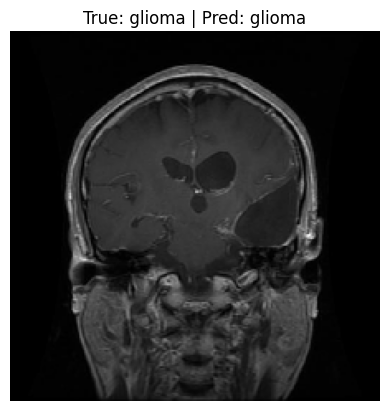

Image: /content/data/Training/glioma/Tr-gl_0012.jpg
Predicted class: glioma
Probabilities: [[9.9987829e-01 9.5686228e-05 2.5994454e-05 2.7369904e-08]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


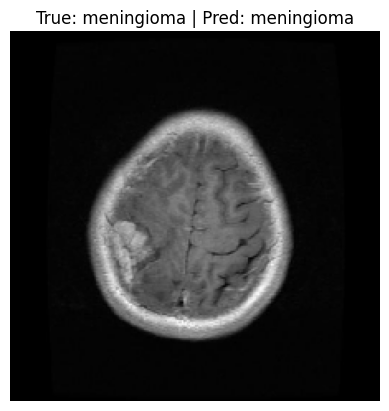

Image: /content/data/Training/meningioma/Tr-me_0012.jpg
Predicted class: meningioma
Probabilities: [[9.624784e-03 9.903751e-01 7.347109e-08 2.125628e-11]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


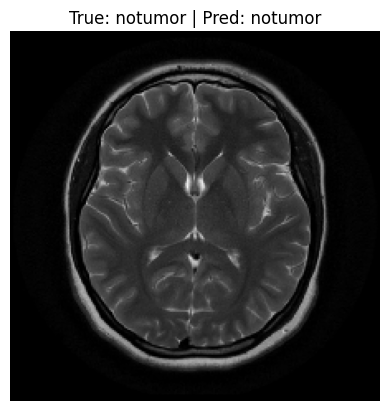

Image: /content/data/Training/notumor/Tr-no_0012.jpg
Predicted class: notumor
Probabilities: [[2.6183139e-05 5.1855524e-05 9.9992192e-01 9.6217201e-11]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


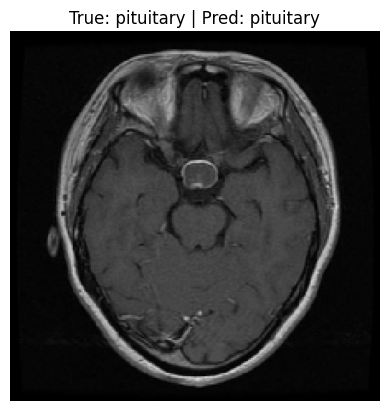

Image: /content/data/Training/pituitary/Tr-pi_0012.jpg
Predicted class: pituitary
Probabilities: [[0.00203331 0.05958622 0.10406172 0.83431876]]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# -------------------------
# Step 1: Class mapping
index_to_class = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
# -------------------------

# -------------------------
# Step 2: Sample image paths for debugging
sample_images = {
    'glioma': "/content/data/Training/glioma/Tr-gl_0012.jpg",
    'meningioma': "/content/data/Training/meningioma/Tr-me_0012.jpg",
    'notumor': "/content/data/Training/notumor/Tr-no_0012.jpg",
    'pituitary': "/content/data/Training/pituitary/Tr-pi_0012.jpg"
}
# -------------------------

# -------------------------
# Step 3: Loop through each sample image and predict
for class_name, path in sample_images.items():
    # Load and preprocess image
    img = load_img(path, target_size=(224, 224), color_mode='rgb')
    input_arr = img_to_array(img) / 255.0
    input_arr_exp = np.expand_dims(input_arr, axis=0)

    # Predict
    pred_prob = model.predict(input_arr_exp)
    pred_class_idx = np.argmax(pred_prob, axis=1)[0]
    pred_class_name = index_to_class[pred_class_idx]

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_name} | Pred: {pred_class_name}")
    plt.show()

    # Print prediction probabilities
    print(f"Image: {path}")
    print(f"Predicted class: {pred_class_name}")
    print(f"Probabilities: {pred_prob}\n")
# -------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


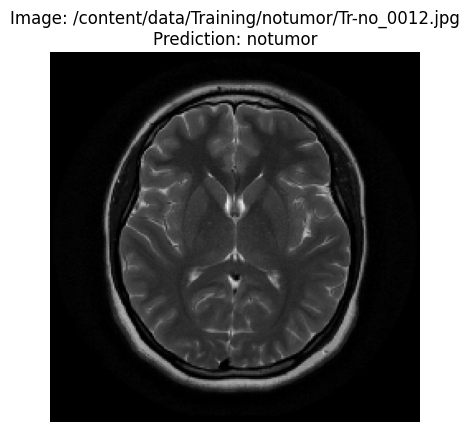

Image: /content/data/Training/notumor/Tr-no_0012.jpg
No tumor detected in the image.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# -------------------------
# Step 1: Set the image path manually to a 'no tumor' image
image_path = "/content/data/Training/notumor/Tr-no_0012.jpg"  # Replace with your 'notumor' image
# -------------------------

# -------------------------
# Step 2: Class mapping
# Make sure it matches your training generator's class indices
index_to_class = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
# -------------------------

# -------------------------
# Step 3: Load and preprocess image
img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
input_arr = img_to_array(img) / 255.0  # normalize
input_arr_exp = np.expand_dims(input_arr, axis=0)
# -------------------------

# -------------------------
# Step 4: Predict
pred_prob = model.predict(input_arr_exp)
pred_class_idx = np.argmax(pred_prob, axis=1)[0]
pred_class_name = index_to_class[pred_class_idx]

# -------------------------
# Step 5: Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {image_path}\nPrediction: {pred_class_name}")
plt.show()

# -------------------------
# Step 6: Check tumor presence
if pred_class_name == 'notumor':
    print(f"Image: {image_path}")
    print("No tumor detected in the image.")
else:
    print(f"Image: {image_path}")
    print(f"Tumor detected: {pred_class_name}")
# -------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


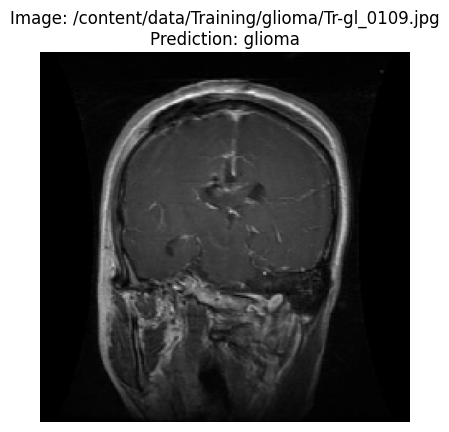

Image: /content/data/Training/glioma/Tr-gl_0109.jpg
Tumor detected: glioma


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# -------------------------
# Step 1: Set the image path manually to a 'no tumor' image
image_path = "/content/data/Training/glioma/Tr-gl_0109.jpg"  # Replace with your 'notumor' image
# -------------------------

# -------------------------
# Step 2: Class mapping
# Make sure it matches your training generator's class indices
index_to_class = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
# -------------------------

# -------------------------
# Step 3: Load and preprocess image
img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
input_arr = img_to_array(img) / 255.0  # normalize
input_arr_exp = np.expand_dims(input_arr, axis=0)
# -------------------------

# -------------------------
# Step 4: Predict
pred_prob = model.predict(input_arr_exp)
pred_class_idx = np.argmax(pred_prob, axis=1)[0]
pred_class_name = index_to_class[pred_class_idx]

# -------------------------
# Step 5: Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {image_path}\nPrediction: {pred_class_name}")
plt.show()

# -------------------------
# Step 6: Check tumor presence
if pred_class_name == 'notumor':
    print(f"Image: {image_path}")
    print("No tumor detected in the image.")
else:
    print(f"Image: {image_path}")
    print(f"Tumor detected: {pred_class_name}")
# -------------------------
